<h1>Klasifikasi Dokumen Berita BBC</h1>

Proyek ini bertujuan untuk mengklasifikasikan dokumen menggunakan Jaringan Saraf Tiruan (JST) (<i>Artificial Neural Network (ANN)</i>). Pada proyek ini kami juga akan menggunakan algoritma non JST yaitu : KNN sebagai metode pembanding. Score TF-IDF akan digunakan sebagai fitur dalam proyek ini, yang dimana selanjutnya dijadikan input untuk jaringan Saraf Tiruan. Dari proses training ini diharapkan mampu menghasilkan model yang handal dalam melakukan klasifikasi dokumen. Adapun alur proyek yang diadaptasikan dalam proyek ini adalah sebagai berikut :
<ol>
  <li>Load Dataset</li>
  <li>Preprocessing Data</li>
    <ul>
      <li>Lowercasing</li>
      <li>Tokenisasi</li>
      <li>Cleaning</li>
      <li>Stopword</li>
      <li>Steming</li>
      <li>Lematisasi</li>
      <li>Data Spliting</li>
    </ul>
  <li>Features Reduction(Optional)</li>
    <ul>
      <li>PCA</li>
      <li>Chi-Square</li>
    </ul>
  <li>Training Phase</li>
    <ul>
      <li>Backpropagation</li>
      <li>RNN</li>
      <li>KNN</li>
    </ul>
  <li>Testing Phase</li>
  <li>Result</li>
    <ul>
      <li>Confusion Matrix</li>
      <li>Accuracy</li>
      <li>Precision</li>
      <li>Recall</li>
      <li>F1 Score</li>
    </ul>
</ol>

<h2>Load Dataset</h2>

Dataset yang digunakan adalah <a href ="https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification">BBC Full Text Document Classification</a>. Dataset ini terdiri atas 2225 dokumen yang dikurasi dari website berita BBC dengan 5 kategori (bussines, entertainment, politics, sport dan tech). Dataset ini dikurasi dari tahun 2004 - 2005.

Sitasi : D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

In [89]:
# Data manipulation libraries.
import numpy as np
import pandas as pd
import spacy

# Data visualization libraries.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# General Imports
import os
import re
from tqdm import tqdm
from colorama import Fore, Style
from collections import Counter
import string

import re
#-------NLTK--------------
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
# from unidecode import unidecode
# from contractions import fix
from nltk.util import ngrams

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from wordcloud import WordCloud


from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV


from sklearn.cluster import KMeans , AgglomerativeClustering, DBSCAN
# from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer,ClusteringScoreVisualizer
from sklearn.metrics import silhouette_score

# Library versions.
# print("NumPy version:", np.__version__)
# print("Spacy version:", spacy.__version__)
# print("Pandas version:", pd.__version__)
# print("Matplotlib version:", matplotlib.__version__)
# print("Seaborn version:", sns.__version__)

<h3>Konstanta</h3>

In [90]:
DATA_DIR = "dataset/"
METADATA_CSV = "doc_metadata.csv"
PARSED_TEXT_CSV = "doc_parsed_text1.csv"
FINAL_CSV = "doc_preprocessed.csv"
SPECIAL_CHARS = r"([^a-z0-9\s])\1+"

<h3>Daftar Fungsi</h3>

In [91]:
def display_as_table(headers, rows, align="r", add_sl_no=False):
    if isinstance(rows, pd.Series):
        rows = list(rows.iteritems())

    table = PrettyTable(align=align)

    if add_sl_no:
        table.field_names = ["No."] + list(headers)
        table.align["No."] = "r"
        rows = [[idx + 1] + list(row) for idx, row in enumerate(rows)]
    else:
        table.field_names = headers

    table.add_rows(rows)
    display(table)


to_dict = lambda frm_list: {item: frm_list.index(item) for item in frm_list}

def plot_elbow(ll, hl, col_name, df, y_label):
    plt.figure(figsize=(4, 3))

    pts = df[col_name].quantile(q=np.arange(ll, hl, 0.01))
    sns.lineplot(x=pts.index, y=pts)
    plt.title(f"{y_label} antara {ll} & {round(hl - 0.01, 2)} percentile")
    plt.xlabel("Percentile")
    plt.ylabel(y_label)

    plt.show()
    
def is_empty(element):
    """
    Function to check if input element is empty.
    """

    if (isinstance(element, int) or isinstance(element, float)) and element == 0:
        # Exclude 0 and 0.0 from the Falsy set.
        return False
    elif isinstance(element, str) and len(element.strip()) == 0:
        # Include string with only one or more empty space(s) into Falsy set.
        return True
    elif isinstance(element, bool):
        # Exclude False from the Falsy set.
        return False
    else:
        return False if element else True

def generate_wordcloud(data,column):
    str_text=data[column].str.cat(sep=" ")    # we have to convert all review into single string
    wordcloud=WordCloud(width=500,height=300,background_color='white').generate(str_text)
    plt.figure(figsize=(10,6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


stopwords_list = stopwords.words('english')
len(stopwords_list)

flags_im = re.IGNORECASE | re.MULTILINE

def preprocess_data(text):
    text = text.lower()
    text = re.sub(SPECIAL_CHARS, " ", text, flags=flags_im)
    text = text.replace("\n"," ").replace("\t"," ")
    text = re.sub("\s+"," ",text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # modul 're' (regex) 
    # semua angka dalam teks diganti dengan string kosong, sehingga dihapus dari teks
    text = re.sub(r"\d+", "", text)

    # menghapus spasi kosong di awal dan akhir teks
    text = text.strip()

    # mencocokkan kata-kata yang mengandung angka, semua kata-kata semacam itu diganti dengan string kosong
    text = re.sub('\w*\d\w*', '', text)

    # mencocokkan tag HTML dan konten di dalamnya, semua tag HTML diganti dengan string kosong
    text = re.sub('<.*?>+', '', text)

    # mencocokkan teks yang ada di antara kurung siku, semua teks dalam kurung siku diganti dengan string kosong
    text = re.sub('\[.*?\]', '', text)

    # mencocokkan URL dengan atau tanpa protokol HTTP(S) dan URL tanpa protokol, semua URL diganti dengan string kosong
    text = re.sub('https?://\S+|www\.\S+', '', text)

    # berisi semua karakter tanda baca, semua tanda baca dalam teks diganti dengan string kosong
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # mengganti semua karakter newline (\n) dengan spasi kosong, sehingga baris-baris baru dihapus
    text = text.replace("\n"," ")

    # mengganti dua spasi kosong berturut-turut dengan satu spasi kosong
    text = text.replace("  "," ")
    
    # tokens
    tokens = word_tokenize(text)
    
    data = [i for i in tokens if i not in punctuation]
    data = [i for i in data if i not in stopwords_list]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    final_text = []
    for i in data:
        word = lemmatizer.lemmatize(i)
        final_text.append(word)
        
    return " ".join(final_text)

In [92]:
if os.path.exists(METADATA_CSV):
    print("Loading metadata from:", METADATA_CSV)
    meta_df = pd.read_csv(METADATA_CSV)
else:
    meta_data = []

    folder_kategori = os.listdir(DATA_DIR)

    for kategori in folder_kategori:
        path_kategori = os.path.join(DATA_DIR, kategori)
        if not os.path.isdir(path_kategori):
            continue

        nama_docs = os.listdir(path_kategori)
        for doc in nama_docs:
            path_doc = path_kategori + "/" + doc
            ukuran_doc = os.path.getsize(path_doc)
            nama_doc, ext = os.path.splitext(doc) 
            doc_id = kategori[0].upper() + "_" + nama_doc
            meta_data.append([kategori.capitalize(), doc_id, ukuran_doc, path_doc])

    nama_kolom = ["Doc_Kategori", "Id_Doc", "Ukuran_Doc", "Path_Doc"]
    meta_df = pd.DataFrame(data=meta_data, columns=nama_kolom)

    meta_df.to_csv(METADATA_CSV, index=False, na_rep="")

meta_df["Doc_Kategori"] = meta_df["Doc_Kategori"].astype("category")

meta_df.sample(10)


,Doc_Kategori,Id_Doc,Ukuran_Doc,Path_Doc
1796,Sport,S_484,1014,dataset/sport/484.txt
2171,Tech,T_348,2590,dataset/tech/348.txt
1639,Sport,S_327,2525,dataset/sport/327.txt
152,Business,B_153,2300,dataset/business/153.txt
33,Business,B_034,1780,dataset/business/034.txt
62,Business,B_063,1747,dataset/business/063.txt
1375,Sport,S_063,1614,dataset/sport/063.txt
1773,Sport,S_461,1767,dataset/sport/461.txt
1624,Sport,S_312,4224,dataset/sport/312.txt
1960,Tech,T_137,5491,dataset/tech/137.txt


Info Dataframe

In [93]:
baris, kolom = meta_df.shape
print(f"Dataset terdiri dari {baris} baris and {kolom} kolom.\n")

meta_df.info()

Dataset terdiri dari 2225 baris and 4 kolom.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Doc_Kategori  2225 non-null   category
 1   Id_Doc        2225 non-null   object  
 2   Ukuran_Doc    2225 non-null   int64   
 3   Path_Doc      2225 non-null   object  
dtypes: category(1), int64(1), object(2)
memory usage: 54.7+ KB


Tidak ada data yang <i>missing</i>

<h3>Jumlah Data Berdasarkan Kategori</h3>

In [94]:
jum_kategori = meta_df["Doc_Kategori"].value_counts()

display_as_table(
  headers = ["Label Kategori", "Jumlah"],
  rows = list(zip(jum_kategori.index, jum_kategori.values)),
  add_sl_no = True
)

No.,Label Kategori,Jumlah
1,Sport,511
2,Business,510
3,Politics,417
4,Tech,401
5,Entertainment,386


<h3>Plot Data Berdasarkan Kategori</h3>

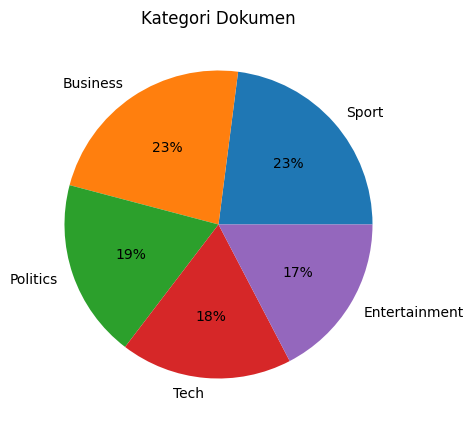

In [95]:
plt.figure(figsize=(5, 5))

plt.pie(x=jum_kategori, labels=jum_kategori.index, autopct="%1.0f%%")
plt.title("Kategori Dokumen")

plt.show()

<h3>Pelabelan Kategori</h3>

In [96]:
codes, uniques = pd.factorize(meta_df["Doc_Kategori"])

cls_map = to_dict(uniques.categories.to_list())
print("Encoded class-labels:\n", cls_map)

meta_df["Doc_Label"] = codes
meta_df["Doc_Label"].value_counts().sort_index()

Encoded class-labels:
 {'Business': 0, 'Entertainment': 1, 'Politics': 2, 'Sport': 3, 'Tech': 4}


Doc_Label
0    510
1    386
2    417
3    511
4    401
Name: count, dtype: int64

<h3>Distribusi Data Berdasarkan Ukuran Dokumen</h3>

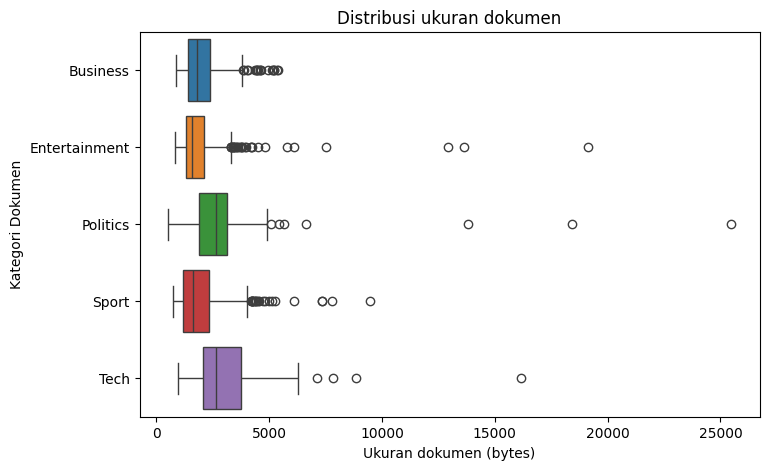

In [97]:
plt.figure(figsize=(8, 5))

sns.boxplot(data=meta_df, x="Ukuran_Doc", y="Doc_Kategori", palette="tab10", hue="Doc_Kategori", legend=False)
plt.title("Distribusi ukuran dokumen")
plt.xlabel("Ukuran dokumen (bytes)")
plt.ylabel("Kategori Dokumen")

plt.show()

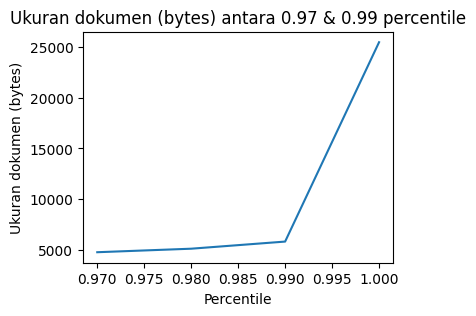

In [98]:
plot_elbow(0.97, 1, "Ukuran_Doc", meta_df, "Ukuran dokumen (bytes)")

<b>Observasi</b>

<ol>
    <li><b>99%</b> dokumen memiliki data ukuran <b>kurang dari ~6 KB.</b></li>
    <li><b>Semua dokumen</b> dengan ukuran data <b>lebih besar dari 6 KB</b> dapat dianggap sebagai <b>outliers.</b></li>
</ol>

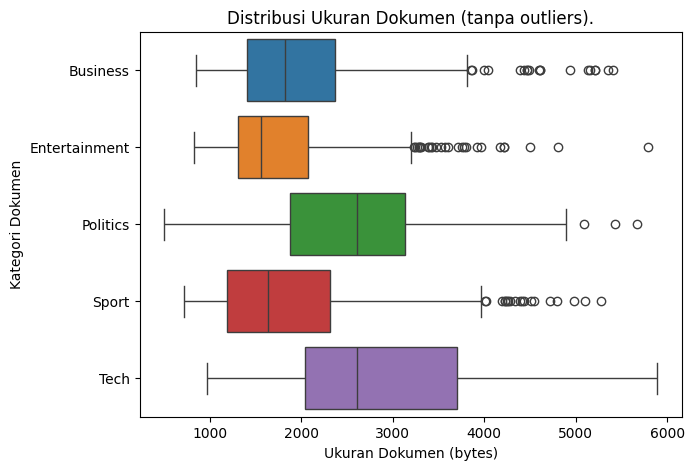

In [99]:
fltr = meta_df["Ukuran_Doc"] < 6_000

plt.figure(figsize=(7, 5))

sns.boxplot(data=meta_df[fltr], x="Ukuran_Doc", y="Doc_Kategori", palette="tab10", hue="Doc_Kategori", legend=False)
plt.title("Distribusi Ukuran Dokumen (tanpa outliers).")
plt.xlabel("Ukuran Dokumen (bytes)")
plt.ylabel("Kategori Dokumen")

plt.show()

In [100]:
gte_6_KB = round(len(meta_df[~fltr]) / baris * 100, 1)
print(f"{gte_6_KB}% of documents are larger than 6 KB.")

0.9% of documents are larger than 6 KB.


<b>Observasi</b>

<ol>
    <li>Distribusi fitur ukuran dokumen tumpang tindih untuk sebagian besar jenis dokumen.</li>
    <li>Tidak ada pola yang terlihat untuk membedakan berbagai jenis dokumen hanya dengan menggunakan fitur ukuran dokumen.</li>
    <li>Karena hanya 0,9% dokumen memiliki ukuran file lebih dari 6 KB, yaitu outlier, mereka dapat dihapus nanti.</li>
    <li>Berkas dengan jenis dokumen teknologi dan politik memiliki ukuran file yang lebih besar dibandingkan dengan yang lainnya.</li>
</ol>

In [101]:
fltr = meta_df["Ukuran_Doc"] > 6_000
outliers = meta_df.loc[fltr, "Doc_Kategori"].value_counts()
lost = np.round(np.divide(outliers.values, jum_kategori.values) * 100, 1)

display_as_table(
    headers=["Class label", "% of data lost per class"],
    rows=list(zip(jum_kategori.index, lost)),
    add_sl_no=True,
)

No.,Class label,% of data lost per class
1,Sport,1.2
2,Business,1.0
3,Politics,1.2
4,Tech,1.0
5,Entertainment,0.0


In [102]:
meta_df.drop(meta_df[fltr].index, inplace=True)

rows_wo, cols_wo = meta_df.shape  # wo :- Without outliers
print(f"Dataset contains {rows_wo} rows and {cols_wo} columns.")

Dataset contains 2205 rows and 5 columns.


In [103]:
# inp_text = """
# OMG!!!! This is line1.

# Is this really line 2????


# Some lengthy line -- to test text preprocessing. Oh! Text in "quotes" are not affected.
# Are these preprocessing steps enough?
# """

# print(preprocess_data(inp_text))

In [104]:
meta_df.head(10)

,Doc_Kategori,Id_Doc,Ukuran_Doc,Path_Doc,Doc_Label
0,Business,B_001,2560,dataset/business/001.txt,0
1,Business,B_002,2252,dataset/business/002.txt,0
2,Business,B_003,1552,dataset/business/003.txt,0
3,Business,B_004,2412,dataset/business/004.txt,0
4,Business,B_005,1570,dataset/business/005.txt,0
5,Business,B_006,1187,dataset/business/006.txt,0
6,Business,B_007,1669,dataset/business/007.txt,0
7,Business,B_008,1922,dataset/business/008.txt,0
8,Business,B_009,1494,dataset/business/009.txt,0
9,Business,B_010,1449,dataset/business/010.txt,0


In [105]:
if os.path.exists(PARSED_TEXT_CSV):
    print("Memuat data text dokumen dari :", PARSED_TEXT_CSV)
    prsd_df = pd.read_csv(PARSED_TEXT_CSV)
else:
    parsed_data = []
    for doc_id, doc_path in tqdm(meta_df[["Id_Doc", "Path_Doc"]].values):

        # Read document as byte-file.
        with open(doc_path, "rb") as txt_f:
            ip_text = txt_f.read().decode("utf-8", errors="ignore").strip()  # Input txt

            if is_empty(ip_text):
                continue

            op_text = preprocess_data(ip_text)

            parsed_data.append([doc_id, len(op_text), op_text])

    # Convert parsed text from documents into a DataFrame.
    nama_kolom = ["Id_Doc", "Panjang_Doc", "Text_Doc"]

    # col_names = ["DocId", "DocTextlen", "DocText"]
    prsd_df = pd.DataFrame(parsed_data, columns=nama_kolom)

    # Save DataFrame as CSV file for future use.
    prsd_df.to_csv(PARSED_TEXT_CSV, index=False, na_rep="")
    print("Data preprocessing text disimpan di:", PARSED_TEXT_CSV)

prsd_df.head()

  0%|          | 0/2205 [00:00<?, ?it/s]

100%|██████████| 2205/2205 [00:26<00:00, 83.17it/s] 


Data preprocessing text disimpan di: doc_parsed_text1.csv


,Id_Doc,Panjang_Doc,Text_Doc
0,B_001,1731,ad sale boost time warner profit quarterly pro...
1,B_002,1561,dollar gain greenspan speech dollar hit highes...
2,B_003,1079,yukos unit buyer face loan claim owner embattl...
3,B_004,1651,high fuel price hit ba profit british airway b...
4,B_005,1092,pernod takeover talk lift domecq share uk drin...


In [106]:
prsd_df.head()

,Id_Doc,Panjang_Doc,Text_Doc
0,B_001,1731,ad sale boost time warner profit quarterly pro...
1,B_002,1561,dollar gain greenspan speech dollar hit highes...
2,B_003,1079,yukos unit buyer face loan claim owner embattl...
3,B_004,1651,high fuel price hit ba profit british airway b...
4,B_005,1092,pernod takeover talk lift domecq share uk drin...


In [107]:
x_train, x_test,y_train,y_test = train_test_split(prsd_df['Text_Doc'],meta_df['Doc_Label'],test_size=0.10, shuffle=True)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1984,)
(221,)
(1984,)
(221,)


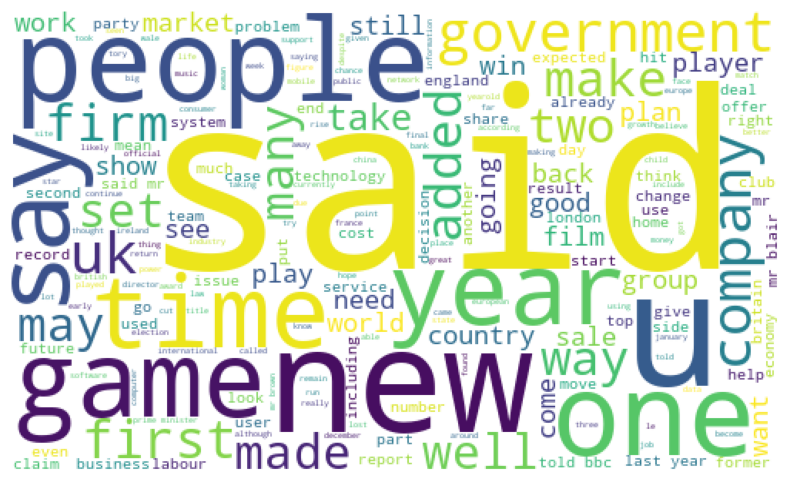

In [108]:
generate_wordcloud(prsd_df,"Text_Doc")

In [109]:
tfidf = TfidfVectorizer(ngram_range=(1,5),max_df=0.95, max_features=15000)

tfidf_train = tfidf.fit_transform(x_train)
tfidf_test = tfidf.transform(x_test)

In [110]:
tfidf_train.A.shape

(1984, 15000)

Confusion Matrix:
[[48  1  5  1  1]
 [ 0 36  1  0  0]
 [ 1  0 33  1  1]
 [ 3  0  0 58  0]
 [ 0  1  1  0 29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        56
           1       0.95      0.97      0.96        37
           2       0.82      0.92      0.87        36
           3       0.97      0.95      0.96        61
           4       0.94      0.94      0.94        31

    accuracy                           0.92       221
   macro avg       0.92      0.93      0.92       221
weighted avg       0.92      0.92      0.92       221



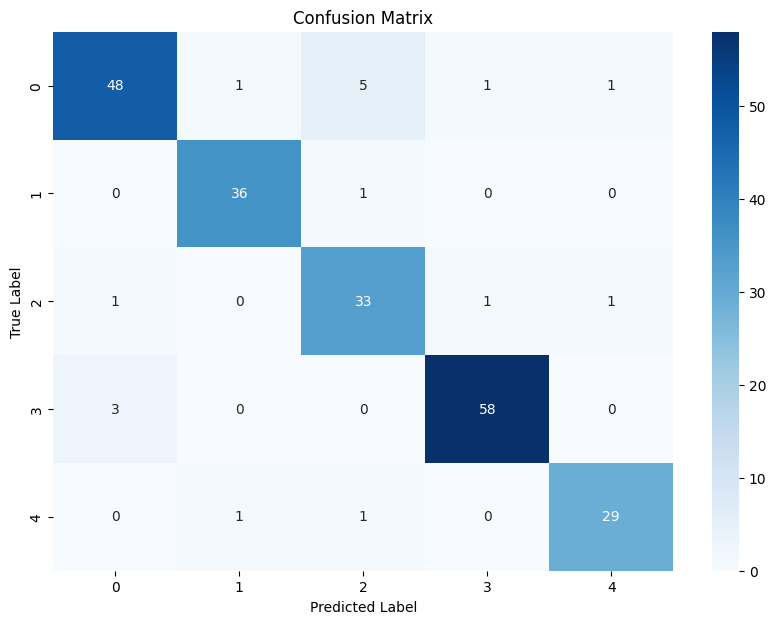

In [111]:
from sklearn.neighbors import KNeighborsClassifier
# Langkah tambahan untuk pemodelan KNN dan Confusion Matrix

# 1. Inisialisasi dan latih model KNN
knn = KNeighborsClassifier(n_neighbors=5)  # Anda dapat mengubah jumlah tetangga sesuai kebutuhan
knn.fit(tfidf_train, y_train)

# 2. Prediksi menggunakan model KNN
y_pred = knn.predict(tfidf_test)

# 3. Hitung Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# 4. Cetak Confusion Matrix dan Classification Report
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualisasi Confusion Matrix menggunakan heatmap
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [66]:
join_text = " ".join(text for text in prsd_df['Text_Doc'])
print ("There are {} words in the combination of all review.".format(len(join_text)))

There are 3390600 words in the combination of all review.
